In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from collections import defaultdict
import time
import torchvision.models as models
import torch.nn as nn

In [ ]:
#https://medium.com/@piyushkashyap045/transfer-learning-in-pytorch-fine-tuning-pretrained-models-for-custom-datasets-6737b03d6fa2

In [2]:
#  Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
#we just use to calculate mean and std values for the images:
def calculate_mean_std_images(train_data):
    sum_channels_pixels = np.zeros(3,)#np.array([0.,0.,0.])
    sum_square_channels_pixels = np.zeros(3,)
    total_pixels  = 0
    for img, _  in train_data:
        #img is PIL.Image instance ==>np array
        Img = np.asarray(img)/255.0
        total_pixels +=np.prod(Img.shape[0:-1])
        #calculate per channel for each array
        sum_channels_pixels += Img.sum(axis=(0,1))
        sum_square_channels_pixels += (Img **2).sum(axis=(0,1))
    mean = sum_channels_pixels / total_pixels
    #Var(X)=E[X ^2]−(E[X])^2
    var = (sum_square_channels_pixels /sum_channels_pixels) - (mean **2)
    std = np.sqrt(var)
    return mean, std

In [4]:
#calculate the mean and std:
Parent_Path = 'D:\\Cellula Technologies\\Project_1\\Teeth DataSet\\'
train_data = torchvision.datasets.ImageFolder(root = Parent_Path +'Training')
m , s = calculate_mean_std_images(train_data)
print(f'the mean per channel for training images: {m}')
print(f'the std per channel for training images: {s}')
#note: it takes a lot of time to calcalate but i just run one time
#future work: we can deal with ToTensor

the mean per channel for training images: [0.73255072 0.50281198 0.47917073]
the std per channel for training images: [0.51907074 0.61126614 0.61097012]


In [5]:
import os
os.listdir(Parent_Path)

['otherFiles', 'Testing', 'Training', 'Validation']

In [5]:
# . Define transforms
Parent_Path = 'D:\\Cellula Technologies\\Project_1\\Teeth DataSet\\'
basic_tranfrom= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(m , s)  # mean and std for MNIST
])
train_transform = transforms.Compose([
    #data Augmentation:
    transforms.RandomRotation(10),#rotation range [0:40]
    transforms.RandomAffine(degrees= 0, translate = (0.2,0.2)),
    transforms.RandomHorizontalFlip(), 
    #transforms.RandomResizedCrop(250, scale = (0.8, 1)),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
    transforms.ToTensor(),
    transforms.Normalize(m , s)  # mean and std for MNIST
])



In [6]:
#load images using ImageFloder: 
train_data = torchvision.datasets.ImageFolder(root = Parent_Path +'Training',transform=train_transform )
validation_data = torchvision.datasets.ImageFolder(root = Parent_Path +'Validation',transform=basic_tranfrom )
test_data = torchvision.datasets.ImageFolder(root = Parent_Path +'Testing',transform=basic_tranfrom)

In [7]:
for k, v in train_data.class_to_idx.items():
    print(k , "    ", v)

CaS      0
CoS      1
Gum      2
MC      3
OC      4
OLP      5
OT      6


In [8]:
#train_data.class_to_idx
labels_count = Counter(train_data.targets)
classes_info = {K:  labels_count[numerical_label]  for K , numerical_label in train_data.class_to_idx.items()} 

In [17]:
classes_info 

{'CaS': 480,
 'CoS': 450,
 'Gum': 360,
 'MC': 540,
 'OC': 324,
 'OLP': 540,
 'OT': 393}

In [9]:
classes_info.values()

dict_values([480, 450, 360, 540, 324, 540, 393])

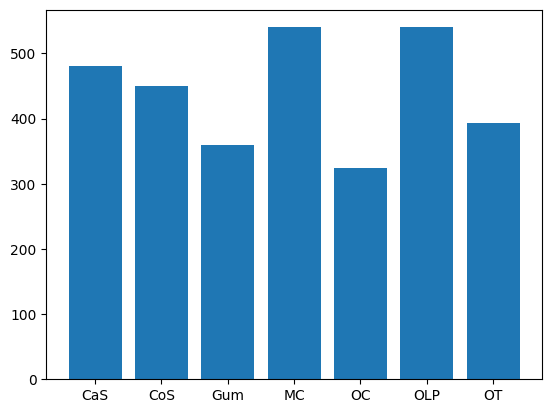

In [10]:
plt.bar(classes_info.keys(), classes_info.values())
plt.show()
#try using px for effiencet drawing



In [11]:
#convert to dataLoader: 
train_loader = DataLoader(train_data , batch_size =64 , shuffle = True)
val_loader = DataLoader(validation_data, batch_size =64 )
test_loader = DataLoader(test_data , batch_size =64 )

In [12]:
#We use VGG-16 as a pretrained model to classify between teeth diseases.
#load Pre-trained VGG16 model:
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
#Replace the classifier of VGG16 model:
model.classifier[6] = nn.Linear(in_features = 4096, out_features = 7)
model = model.to(device)
#After APDUTINGG
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
#we freeze the feature layers and train only classifier layers:
for param in model.parameters():
    param.requires_grad  = False
#then enable classifier layers to be trainable layers:
for param in model.classifier.parameters():
    param.requires_grad = True

In [15]:
#convert the training to a function:
def train(  model,
            optimizer,
            criterion,
            device,
            dataset_loader,
            val_loader,
            epochs_,
            finished_epochs,
            PATH
        ):
    #training procedure:
    history = defaultdict(list)
    start_time = time.time()
    #for long training peroids:
    #if the training intruppted because the session time is gone or any other problem
    epochs = epochs_ - finished_epochs
    current_epoch = finished_epochs
    print("The training is strating from epoch: ",current_epoch)
    print("**************************************")
    #when we need to save the model weights for learning for many times not one time
    patience = 15
    counter = 0
    best_val_loss = float('inf')
    for epoch in range(epochs):
        loss_per_epoch = 0
        Acc_train = 0
        Acc_val = 0
        for feature , labels in train_loader:
            #to GPU
            epoch_start_time = time.time()
            feature, labels = feature.to(device), labels.to(device)
            # forward
            logits= model(feature)
            # calculate loss fn
            loss = criterion(logits, labels)
            loss_per_epoch += loss.item()
            Acc_train += (logits.argmax(dim =1) == labels).sum().item() / len(labels)
            # reset gradients
            optimizer.zero_grad()
            # calculate gradients
            loss.backward()
            # update weights
            optimizer.step()
        
        #UserWarning: Using a target size (labels)(torch.Size([64])) that is different to the input size (y_predict)(torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
        # warning that make results wrong
        loss_per_epoch /= len(train_loader)
        Acc_train /= len(train_loader)
        loss_per_epoch /= len(train_loader)
        history['train_loss'].append(loss_per_epoch)
        history['train_acc'].append(Acc_train)
        # validation Check
        with torch.no_grad():
            validation_loss = 0
            for x_valid , y_valid in val_loader:
                x_valid, y_valid = x_valid.to(device), y_valid.to(device)
                logits = model(x_valid)
                loss = criterion(logits, y_valid)
                validation_loss += loss.item()
                Acc_val += (logits.argmax(dim = 1) == y_valid).sum().item() / len(y_valid)
            validation_loss /= len(val_loader)
            Acc_val /= len(val_loader)
            #checking for Early Stopping:
            if validation_loss < best_val_loss:#this true when validation loss is always decreases
                best_val_loss = validation_loss
                counter = 0
            else: #this will happen when validation loss increases or remain the same
                counter += 1
                if counter >= patience:
                    print("Early Stopping")
                    #save weights
                    #torch.save(estimator.state_dict(), PATH + 'model_weights.pth')
                    #pickle.dump(history,open(PATH+'history.pkl','wb') )
                    return history
            history['val_loss'].append(validation_loss)
            history['val_acc'].append(Acc_val)
            current_epoch += 1
            #if epoch %10 ==0:
            #save weights
                #finished_epochs = current_epoch
                #we need to save finished_epochs:
                #pickle.dump(finished_epochs, open(PATH + 'finished_epochs.pkl', 'wb'))#save object
                #pickle.dump(history,open(PATH+'history.pkl','wb') )#save history
                #torch.save(estimator.state_dict(), PATH + 'model_weights.pth')
        print(f"epoch:{current_epoch}, loss_Train: {loss_per_epoch:0.3f} ,Acc_train: {Acc_train * 100:0.3f}, loss_Validation: {validation_loss}, Acc_valid:{Acc_val * 100:0.3f}", end=' ')
        print(f"Time Elapsed: {(time.time() - epoch_start_time)/60 :0.2f} min")
    print(f"Total Time Elapsed:  {(time.time() - start_time)/60 :0.2f} min")
    return history


In [16]:
hist = train(
            model = model,
            optimizer = optimizer ,
            criterion = criterion,
            device = device,
            dataset_loader = train_loader ,
            val_loader = val_loader,
            epochs_ = 20,
            finished_epochs = 0,
            PATH = None
)


The training is strating from epoch:  0
**************************************
epoch:1, loss_Train: 0.036 ,Acc_train: 32.776, loss_Validation: 1.2567795024198645, Acc_valid:50.919 Time Elapsed: 1.23 min
epoch:2, loss_Train: 0.025 ,Acc_train: 53.440, loss_Validation: 0.9796281018677879, Acc_valid:64.982 Time Elapsed: 1.23 min
epoch:3, loss_Train: 0.021 ,Acc_train: 62.847, loss_Validation: 0.8904960926841287, Acc_valid:70.312 Time Elapsed: 1.24 min
epoch:4, loss_Train: 0.018 ,Acc_train: 68.852, loss_Validation: 0.9355491224457236, Acc_valid:70.221 Time Elapsed: 1.24 min
epoch:5, loss_Train: 0.018 ,Acc_train: 69.345, loss_Validation: 0.7760070898186635, Acc_valid:72.702 Time Elapsed: 1.19 min
epoch:6, loss_Train: 0.016 ,Acc_train: 72.900, loss_Validation: 0.6188989272615051, Acc_valid:78.309 Time Elapsed: 1.24 min
epoch:7, loss_Train: 0.015 ,Acc_train: 74.766, loss_Validation: 0.7204663775114836, Acc_valid:79.044 Time Elapsed: 1.28 min
epoch:8, loss_Train: 0.015 ,Acc_train: 75.476, loss_V

In [17]:
def learning_curve(histroy = hist, graph = 'loss'):
    #draw learing Curves:#losses
    if graph == 'loss':
        plt.plot(hist['train_loss'], label = 'train loss')
        plt.plot(hist['val_acc'], label = 'valid loss')
        plt.legend()
        plt.grid(True)
        plt.show()
    if graph == 'ACC':
        plt.plot(hist['train_acc'], label = 'train Acc')
        plt.plot(hist['val_acc'], label = 'valid Acc')
        plt.legend()
        plt.grid(True)
        plt.show()

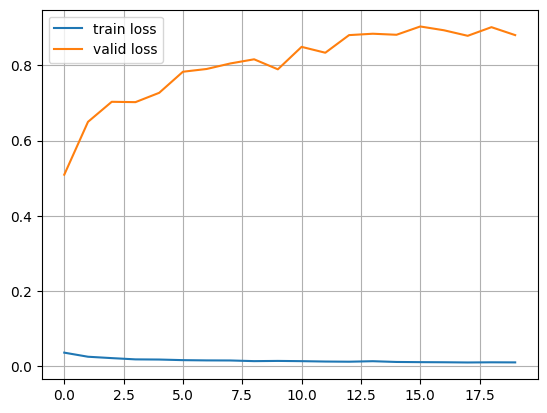

In [18]:
learning_curve(histroy = hist, graph = 'loss')

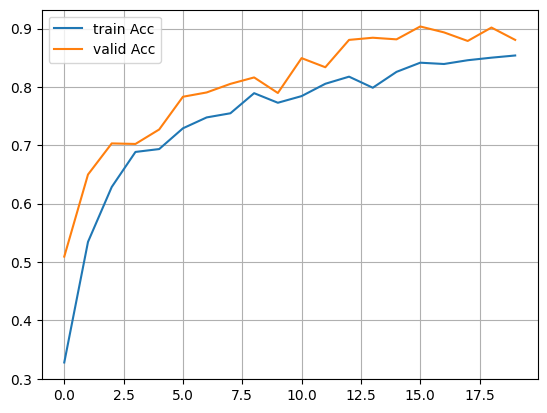

In [19]:
learning_curve(histroy = hist, graph = 'ACC')

In [21]:
#test data to measure the performance of neural network
y_true = []
y_pred = []
with torch.no_grad():
    for features, target in test_loader:
      features, labels = features.to(device), target.to(device)
      logits= model(features)
      y_true.extend(target.cpu().numpy())#convert from pytorch to numpy
      y_pred.extend(logits.argmax(dim=1).cpu().numpy())

In [22]:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from seaborn import heatmap
labels = list (classes_info.keys())

In [23]:
labels

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

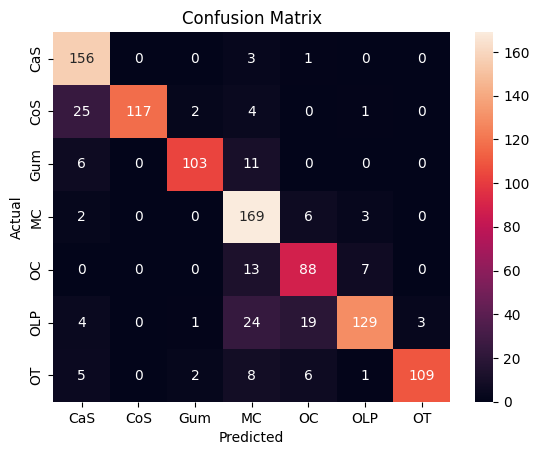

In [24]:
cm = confusion_matrix(y_true ,y_pred)
heatmap(cm, annot = True, fmt = 'd',
        xticklabels=labels,
        yticklabels = labels)
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

In [25]:
print("Acc: ", accuracy_score(y_true ,y_pred))
print("Classification report:\n ", classification_report(y_true ,y_pred))

Acc:  0.8472762645914397
Classification report:
                precision    recall  f1-score   support

           0       0.79      0.97      0.87       160
           1       1.00      0.79      0.88       149
           2       0.95      0.86      0.90       120
           3       0.73      0.94      0.82       180
           4       0.73      0.81      0.77       108
           5       0.91      0.72      0.80       180
           6       0.97      0.83      0.90       131

    accuracy                           0.85      1028
   macro avg       0.87      0.85      0.85      1028
weighted avg       0.87      0.85      0.85      1028



In [26]:
features.shape

torch.Size([4, 3, 256, 256])

In [28]:

model.eval()
with torch.no_grad():
    example_input = torch.randn(features.shape).to(device)
    VGG_16_model = torch.jit.trace(model, example_input)

In [30]:

# Save the scripted model
PATH = 'D:\\Cellula Technologies\\Project_2\\Estimators\\'
VGG_16_model.save(PATH + "VGG_16_model.pt")
     